# Huggingface Model Hubs

## 학습 목표
1. Huggingface model hub 사용법을 살펴본다.

**Context**
1. Text Classification with BERT
2. Language Modeling with GPT
3. Machine Translation with BART

#0. 필요한 패키지 및 라이브러리 import 하기

In [ ]:
!pip install portalocker

In [ ]:
!pip install torchdata

In [ ]:
!pip install transformers

In [ ]:
!pip install sentencepiece

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

from torchtext.datasets import CoLA

from transformers import AutoConfig, AutoTokenizer, AutoModelForSequenceClassification, AutoModelForCausalLM, AutoModelForSeq2SeqLM

from tqdm import tqdm

## 1. Text Classification with BERT

```
💡 Huggingface Model Hub 란❓

앞서 Huggingface Tokenizer 실습에서 언급했듯이, Huggingface 라이브러리에는 사전학습된 tokenizer 뿐만 아니라
언어 모델(PLM, pre-trained model) 및 자연어처리 학습에 유용한 다양한 유틸리티들을 모아두었다는 것을 배웠다.

Transformer 기반 언어 모델(e.g., BERT, GPT, BART) 등 다양한 모델의 pre-trained weight를 바로 불러올 수 있고,
Huggingface model hub가 바로 그런 모델들을 모아둔 곳이다.

논문에서 공개된 공식 모델들 뿐만 아니라 아무나 model hub에 자신의 모델 weight를 올릴 수 있고,
아무나 model hub에서 이러한 모델들을 사용할 수 있다.

사전학습(pre-training)은 굉장히 많은 리소스를 요구하기 때문에,
이런 사전학습 모델들을 사용한다면 AI 언어 모델 연구 및 개발에 있어서 많은 시간과 돈을 아낄 수 있다.
```

### 1-1. 데이터 불러오기

```
✨ Huggingface 라이브러리에 있는 BERT 모델을 가지고 text classification 태스크를 수행한다.

Tokenization 실습에서 사용했던 CoLA 데이터셋은 문법 감정 데이터셋으로써,
문장이 문법적인지 문법적이지 않은지 분류하는 binary classification 태스크에 활용된다.

각 데이터 샘플마다 문장과 해당 라벨이 존재하고,
라벨이 0이라면 문법이 틀린 문장이고, 1이라면 문법이 맞는 문장을 뜻한다.

8,550개의 training data, 526개의 validation data, 515개의 test data로 구성되어 있다.
```

참고1: https://pytorch.org/text/stable/datasets.html#cola

참고2: https://nyu-mll.github.io/CoLA/

In [ ]:
train_iter = CoLA(split='train')
valid_iter = CoLA(split="dev")
test_iter = CoLA(split='test')

print("# train:", len(list(train_iter)))
print("# valid:",len(list(valid_iter)))
print("# test:",len(list(test_iter)))

# train: 8550
# valid: 526
# test: 515


In [ ]:
# 데이터셋 예제
for doc_id, label, sent in train_iter:
    print(f"Doc ID: {doc_id}")
    print(f"Label: {label}")
    print(f"Sentence: {sent}")
    break

Doc ID: gj04
Label: 1
Sentence: One more pseudo generalization and I'm giving up.


### 1-2. BERT config, tokenizer, model

> `AutoConfig`, `AutoTokenizer`, `AutoModelForSequenceClassification` 클래스로 "bert-base-uncased" weight를 불러온다.
>
> 이들은 각각 auto class로써, pre-trained model path에 따라 모델을 유추한다.
>
> "bert-base-uncased"는 BERT 모델로 유추가 가능하다.
>
> "bert-base-uncased"는 lowercasing 전처리가 적용된 BERT 베이스 모델이다.

In [ ]:
config = AutoConfig.from_pretrained("bert-base-uncased")
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=1)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

> `config`를 프린트하면 해당 모델의 configuration (setting)을 확인할 수 있다.

In [ ]:
config

BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.26.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

> `config`에 존재하는 key의 value 값들을 손쉽게 불러올 수 있다.

In [ ]:
print(config.pad_token_id)

0


In [ ]:
print(config.vocab_size)

30522


> 사용자가 정의한 key와 value 값들을 config에 추가할 수도 있다.

In [ ]:
config.custom_setting = 1234
print(config)

BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "custom_setting": 1234,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.26.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}



> Default setting에는 존재하지 않지만, 추가하면 인식되는 파라미터들도 있다.
>
> 대표적으로 `num_labels`를 추가하면 `id2label`과 `label2id`가 자동으로 추가되는 것을 확인할 수 있다.
>
> 이런 특수 파라미터들은 documentation을 참고하기 바란다.

참고: https://huggingface.co/docs/transformers/main_classes/configuration

In [ ]:
config.num_labels = 1
print("# labels:", config.num_labels)
print(config)

# labels: 1
BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.26.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}



> 특수 파라미터들은 처음에 `config`를 선언할 때 바로 추가할 수도 있다.

In [ ]:
config = AutoConfig.from_pretrained("bert-base-uncased", num_labels=1)
print("# labels:", config.num_labels)
print(config)

# labels: 1
BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.26.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}



> `tokenizer`를 프린트하면 해당 모델의 tokenizer를 확인할 수 있다.

In [ ]:
tokenizer

BertTokenizerFast(name_or_path='bert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

> `tokenizer`의 파라미터 값들도 손쉽게 불러올 수 있다.

In [ ]:
print("Unknown 토큰:", tokenizer.unk_token)
print("Separator 토큰:", tokenizer.sep_token)
print("Padding 토큰:", tokenizer.pad_token)
print("Classification 토큰:", tokenizer.cls_token)
print("Mask 토큰:", tokenizer.mask_token)

Unknown 토큰: [UNK]
Separator 토큰: [SEP]
Padding 토큰: [PAD]
Classification 토큰: [CLS]
Mask 토큰: [MASK]


> Special token 고유번호(id)들은 프린트 되지 않았지만 존재한다.

In [ ]:
print("Unknown 토큰:", tokenizer.unk_token_id)
print("Separator 토큰:", tokenizer.sep_token_id)
print("Padding 토큰:", tokenizer.pad_token_id)
print("Classification 토큰:", tokenizer.cls_token_id)
print("Mask 토큰:", tokenizer.mask_token_id)

Unknown 토큰: 100
Separator 토큰: 102
Padding 토큰: 0
Classification 토큰: 101
Mask 토큰: 103


> `vocab_size` 같은 경우 `len()` 함수로도 불러올 수 있다.

In [ ]:
print(tokenizer.vocab_size)
print(len(tokenizer))

30522
30522


> 사용자가 정의한 custom special token도 추가할 수 있다.

In [ ]:
new_tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

In [ ]:
custom_tokens_dict = {'additional_special_tokens': []}
custom_tokens_dict['additional_special_tokens'].append("[SPECIAL]")

new_tokenizer.add_special_tokens(custom_tokens_dict)
print(new_tokenizer)
print("# vocab:", len(new_tokenizer))

BertTokenizerFast(name_or_path='bert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]', 'additional_special_tokens': ['[SPECIAL]']})
# vocab: 30523


> 커스텀 특수 토큰을 추가하면 커스텀 특수 토큰을 잘 토크나이징 하는 것을 확인할 수 있다.

In [ ]:
print(tokenizer.tokenize("Can it tokenize [SPECIAL] token properly?"))
print(new_tokenizer.tokenize("Can it tokenize [SPECIAL] token properly?"))

['can', 'it', 'token', '##ize', '[', 'special', ']', 'token', 'properly', '?']
['can', 'it', 'token', '##ize', '[SPECIAL]', 'token', 'properly', '?']


```
🚨 Tokenizer에 새로운 특수 토큰을 추가할 때 주의할 점

Tokenizer에 새로운 특수 토큰을 추가한다는 것은, 해당 model의 embedding layer 크기가 바뀐다는 뜻이다.
이것에 대한 조치를 취하지 않을 경우 차원이 맞지 않는다는 오류를 접할 것이다.
이 경우 간단하게 모델의 embedding layer 크기를 다음과 같이 늘려줄 수 있다.

>> model.resize_token_embeddings(len(new_tokenizer))

이러면 사전학습 된 embedding layer가 초기화가 되는 건 아닌가 걱정할 수도 있는데,
기존의 토큰 임베딩 pre-trained weight는 그대로 두고 특수 토큰 임베딩 weight만 randomly initialize 된다.
```

참고: https://github.com/huggingface/tokenizers/issues/247

```
💡 Tokenizer vs. TokenizerFast

Tokenizer를 프린트하면 TokenizerFast로 되어 있는 것을 확인할 수 있는데, 이는 TokenizerFast가 default로 불러와지기 때문이다.

토크나이저 선언 시 use_fast=False 파라미터를 주면 상대적으로 느린 Tokenizer를 불러오게 되는데,
이 둘의 차이점은 이름에서 언급되듯 '처리 속도'에 있다.

Tokenizer은 Python 기반 코드로 돌아가는 반면, TokenizerFast는 Rust 기반 코드로 돌아간다.
하나의 문장을 토크나이징 할 시에는 속도 체감이 되지 않지만,
방대한 양의 데이터셋을 병렬적으로 처리해야 할 경우 속도가 최대 20배까지 차이가 난다고 한다.

그러므로 가능하다면 항상 TokenizerFast를 쓰는 것을 권장한다.
```

> `model`을 프린트하면 해당 모델의 구조를 확인할 수 있다.
>
> `AutoModelForSequenceClassification`이기에 마지막 layer에 classifier가 추가된 것을 확인할 수 있다.

In [ ]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

> 특정 layer 및 weight와 bias를 바로 불러올 수 있다.

In [ ]:
print(model.classifier)

Linear(in_features=768, out_features=1, bias=True)


In [ ]:
print(model.classifier.weight)

Parameter containing:
tensor([[ 2.0547e-02, -4.0205e-02, -4.2744e-03,  4.6515e-03,  4.0983e-02,
         -2.1730e-02,  2.6746e-02, -7.7927e-03, -1.1677e-02, -8.3372e-03,
         -2.3166e-03,  1.5348e-02,  3.2257e-02,  5.5757e-03, -3.3736e-02,
          1.5492e-03,  6.8601e-03, -4.1080e-03,  4.4569e-02, -2.4000e-02,
          4.2440e-03,  1.3049e-02, -3.8554e-02,  3.3096e-04,  1.8776e-03,
         -4.4967e-03,  4.5872e-03, -2.3257e-02, -2.6449e-02,  1.9809e-02,
          4.0135e-03, -2.3341e-02, -2.9240e-02,  3.3765e-02, -1.6471e-02,
         -1.0870e-02, -1.8119e-02,  1.2587e-03,  1.1730e-02,  4.4564e-02,
         -3.4202e-03,  1.3524e-02,  4.2300e-03,  3.1620e-03, -1.9006e-02,
          1.9493e-02,  1.3747e-02, -4.7587e-03,  2.0623e-03,  5.8190e-03,
         -5.2877e-03,  4.4031e-03,  1.9246e-03, -7.8648e-04, -3.8993e-02,
         -1.9704e-02,  7.8279e-04, -1.0640e-03,  1.9300e-02,  1.0111e-02,
          5.2257e-03, -3.3558e-03, -2.3659e-02,  2.8069e-02, -4.9758e-02,
          1.2988

In [ ]:
print(model.classifier.bias)

Parameter containing:
tensor([0.], requires_grad=True)


> `named_paramters()` 함수를 통해 모델 layer마다 name과 weight를 확인할 수 있다.

In [ ]:
for name, param in model.named_parameters():
    print(f"{param.shape}\t{name}")

torch.Size([30522, 768])	bert.embeddings.word_embeddings.weight
torch.Size([512, 768])	bert.embeddings.position_embeddings.weight
torch.Size([2, 768])	bert.embeddings.token_type_embeddings.weight
torch.Size([768])	bert.embeddings.LayerNorm.weight
torch.Size([768])	bert.embeddings.LayerNorm.bias
torch.Size([768, 768])	bert.encoder.layer.0.attention.self.query.weight
torch.Size([768])	bert.encoder.layer.0.attention.self.query.bias
torch.Size([768, 768])	bert.encoder.layer.0.attention.self.key.weight
torch.Size([768])	bert.encoder.layer.0.attention.self.key.bias
torch.Size([768, 768])	bert.encoder.layer.0.attention.self.value.weight
torch.Size([768])	bert.encoder.layer.0.attention.self.value.bias
torch.Size([768, 768])	bert.encoder.layer.0.attention.output.dense.weight
torch.Size([768])	bert.encoder.layer.0.attention.output.dense.bias
torch.Size([768])	bert.encoder.layer.0.attention.output.LayerNorm.weight
torch.Size([768])	bert.encoder.layer.0.attention.output.LayerNorm.bias
torch.Size([

> Children layer 같은 경우 바로 프린트 할 수가 없다. 그럴 경우 `get_parameter()` 함수로 weight를 확인할 수 있다.

In [ ]:
print(model.encoder.layer.10.attention.self.query.weight)

SyntaxError: ignored

In [ ]:
print(model.get_parameter('bert.encoder.layer.10.attention.self.query.weight'))

Parameter containing:
tensor([[ 7.1212e-04,  3.7436e-02, -8.1037e-03,  ..., -6.3732e-02,
         -9.5217e-04,  9.4325e-03],
        [-8.5306e-03,  2.1923e-02,  3.7563e-02,  ..., -2.5715e-02,
          4.9945e-02,  1.4635e-02],
        [ 1.7770e-02, -4.4673e-02,  2.7443e-02,  ...,  5.2510e-05,
         -2.2302e-02, -2.1553e-02],
        ...,
        [-2.2598e-03, -1.3400e-02,  1.9143e-02,  ..., -7.8677e-02,
          3.4674e-02, -2.0308e-02],
        [-3.6355e-02,  2.1299e-02,  9.1749e-03,  ..., -2.3351e-02,
          4.4595e-02, -1.0835e-01],
        [ 7.1196e-02, -2.0205e-02,  5.8498e-02,  ...,  1.0116e-01,
          1.8773e-02, -6.1368e-02]], requires_grad=True)


> `requires_grad` 함수를 통해 gradient가 흐르는 파라미터를 확인할 수 있다.

In [ ]:
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'The model has {num_params:,} trainable parameters')

The model has 109,483,009 trainable parameters


> 사용자가 정의한 `config`를 모델 선언 시 파라미터로 줄 수도 있다.
>
> `num_labels`를 이미 정의한 config를 받으면 모델 선언 시 따로 `num_labels`를 정의할 필요가 없다.

In [ ]:
# model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=1)     # 기존 모델 선언
model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", config=config)
print(model)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

> 데이터 로더를 위한 `Dataset` 클래스를 구현한다.

In [ ]:
class CoLADataset(Dataset):
    def __init__(self, config, tokenizer, split):
        self.config = config
        self.tokenizer = tokenizer
        self.split = split

        self.x = []
        self.y = []

        self.__build_dataset()

    def __build_dataset(self):
        if self.split == "train":
            dataset = train_iter
        elif self.split == "dev":
            dataset = valid_iter
        elif self.split == "test":
            dataset = test_iter

        for _, label, sent in tqdm(dataset, desc=f"Building {self.split} dataset"):
            self.x.append(self.tokenizer.encode(sent))
            self.y.append(label)

    def collate_fn(self, batch):
        PAD = self.config.pad_token_id

        max_len = max([len(b[0]) for b in batch])
        input_ids = [b[0] + [PAD] * (max_len - len(b[0])) for b in batch]
        attention_mask = [[1] * len(b[0]) + [0] * (max_len - len(b[0])) for b in batch]
        labels = [b[1] for b in batch]

        input_ids = torch.LongTensor(input_ids)
        attention_mask = torch.LongTensor(attention_mask)
        labels = torch.FloatTensor(labels)
        return {"input_ids": input_ids, "attention_mask": attention_mask, "labels": labels}

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [ ]:
train_set = CoLADataset(config, tokenizer, split="train")
valid_set = CoLADataset(config, tokenizer, split="dev")
test_set = CoLADataset(config, tokenizer, split="test")

Building train dataset: 8550it [00:00, 9937.50it/s] 
Building dev dataset: 526it [00:00, 9909.56it/s]
Building test dataset: 515it [00:00, 9110.67it/s]


In [ ]:
batch_size = 8
learning_rate = 5e-5
epochs = 3
criterion = nn.BCEWithLogitsLoss(reduction="mean")
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"Device: {device}")

Device: cuda


In [ ]:
collate_fn = train_set.collate_fn   # same for all datasets

train_loader = DataLoader(train_set,
                          batch_size=batch_size,
                          shuffle=True,
                          collate_fn=collate_fn,
                          drop_last=True,
                          pin_memory=True)
valid_loader = DataLoader(valid_set,
                          batch_size=batch_size,
                          shuffle=False,
                          collate_fn=collate_fn,
                          drop_last=False)
test_loader = DataLoader(test_set,
                         batch_size=batch_size,
                         shuffle=False,
                         collate_fn=collate_fn,
                         drop_last=False)

 47%|████▋     | 501/1068 [00:44<00:50, 11.22it/s]

Epoch:  1| Step   500	| Loss: 0.562


 94%|█████████▍| 1002/1068 [01:26<00:05, 11.67it/s]

Epoch:  1| Step  1000	| Loss: 0.536


100%|██████████| 1068/1068 [01:32<00:00, 11.60it/s]


Epoch:  1| Step  1068	| Loss: 0.467


 41%|████      | 433/1068 [00:37<00:47, 13.26it/s]

Epoch:  2| Step  1500	| Loss: 0.350


 87%|████████▋ | 933/1068 [01:20<00:11, 11.90it/s]

Epoch:  2| Step  2000	| Loss: 0.362


100%|██████████| 1068/1068 [01:33<00:00, 11.37it/s]


Epoch:  2| Step  2136	| Loss: 0.537


 34%|███▍      | 366/1068 [00:35<00:58, 11.99it/s]

Epoch:  3| Step  2500	| Loss: 0.237


 81%|████████  | 865/1068 [01:14<00:17, 11.74it/s]

Epoch:  3| Step  3000	| Loss: 0.241


100%|██████████| 1068/1068 [01:30<00:00, 11.77it/s]


Epoch:  3| Step  3204	| Loss: 0.564


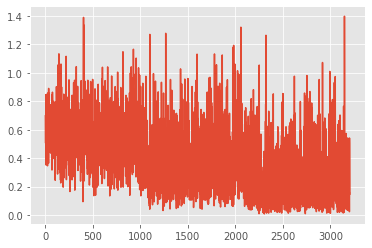

In [ ]:
step = 0
steps = []
loss_list = []
model = model.to(device)

for e in range(epochs):
    train_loss = 0.0
    valid_loss = 0.0

    model.train()
    for i, inputs in enumerate(tqdm(train_loader)):
        for k, v in inputs.items():
            inputs[k] = v.to(device)

        # labels까지 주면 loss를 계산해주지만, 여기서는 custom loss function을 사용하기에 loss를 파라미터로 주지 않는다.
        out = model(inputs["input_ids"], inputs["attention_mask"])

        optimizer.zero_grad()
        loss = criterion(out.logits.squeeze(-1), inputs['labels'])
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        step += 1
        steps.append(step)
        loss_list.append(loss.item())

        if step % 500 == 0 and i != 0:
            print(f'Epoch: {e+1:2d}| Step {step:5d}\t| Loss: {train_loss/(i):.3f}')

    model.eval()
    with torch.no_grad():
        for i, inputs in enumerate(valid_loader):
            for k, v in inputs.items():
                inputs[k] = v.to(device)

            out = model(inputs["input_ids"], inputs["attention_mask"])
            loss = criterion(out.logits.squeeze(-1), inputs['labels'])
            valid_loss += loss.item()

        print(f'Epoch: {e+1:2d}| Step {step:5d}\t| Loss: {valid_loss/(i):.3f}')

plt.plot(steps, loss_list)

In [ ]:
# 추론
model.eval()
acc = []

with torch.no_grad():
    for i, inputs in enumerate(test_loader):
        for k, v in inputs.items():
            inputs[k] = v.to(device)

        out = model(inputs["input_ids"], inputs["attention_mask"])

        probs = torch.sigmoid(out.logits.squeeze(-1))   # sigmoid로 logit을 0과 1사이 값으로 설정
        preds = torch.zeros_like(probs).to(probs)
        preds[probs > 0.5] = 1.                         # 0.5보다 크면 1로 예측
        num_correct = ((preds == 1) * (inputs["labels"] == 1)).sum()
        acc.append(num_correct / len(inputs["labels"]))

print(f"Average accuracy: {sum(acc) / len(acc)}")

Average accuracy: 0.6506410241127014


## 2. Language Modeling with GPT

```
다음은 Transformer decoder를 사전학습 한 GPT 모델을 불러온다.

위에서는 사전학습 된 BERT 모델을 가지고 원하는 태스크(text classification)에 fine-tuning을 하는 과정을 수행하였다.
사전학습 된 모델은 추가로 학습하지 않아도 어느 정도 준수한 성능을 보여주지만,
풀고자 하는 태스크에 추가 학습(이를 fine-tuning이라 칭함)을 할 경우 보다 훨씬 높은 성능을 도출할 수 있다.

하지만 GPT 같은 생성 모델은 사전학습 목표(pre-training objective)가 language modeling,
즉 언어를 생성하도록 사전 학습이 되었기 때문에 특정 데이터셋에 fine-tuning을 하지 않고도 언어를 잘 생성하는 것을 확인할 수 있다.

이를 살펴보기 위해 DistilGPT-2 모델을 사용한다.
DistilGPT-2 모델은 GPT-2 모델 중 가장 작은 모델이다.
```

> Tokenizer는 BERT와 똑같이 `AutoTokenizer`를 사용하고 "distilgpt2" 모델 경로로 `GPT2Tokenizer`를 불러온다.
>
> `AutoModelForCausalLM` 클래스로 GPT-2 계열의 모델을 불러올 시 `GPT2LMHeadModel`이 선언된다.
>
> LM head 모델은 Transformer 위에 LM layer가 추가된다. LM layer는 `vocab_size` 크기의 linear layer이다.
>
> Config는 굳이 필요 없다면 불러오지 않아도 된다.

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("distilgpt2")
model = AutoModelForCausalLM.from_pretrained("distilgpt2", pad_token_id=tokenizer.eos_token_id) # causal LM 모델 경우 패딩 토큰을 EOS 토큰과 동일하게 해주어야 한다. (Documentation 참고)

In [ ]:
tokenizer

GPT2TokenizerFast(name_or_path='distilgpt2', vocab_size=50257, model_max_length=1024, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<|endoftext|>', 'eos_token': '<|endoftext|>', 'unk_token': '<|endoftext|>'})

In [ ]:
model

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dro

> 모델 파라미터 수가 굉장히 적은 것을 확인할 수 있다.
>
> DistilGPT-2 (82M, 8200만) vs. ChatGPT (175B, 1750억)

In [ ]:
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'The model has {num_params:,} trainable parameters')

The model has 81,912,576 trainable parameters


> 프롬프트(prompt) string을 조건으로 주었을 때, 그 다음 나올 단어들을 생성한다. Fine-tuning 없이도 어느 정도 생성하는 것을 확인할 수 있다. 하지만 모델이 작은 만큼 생성하는 결과물들이 다소 정확하다거나 다채로운 단어 선택을 하지 못한다.

In [ ]:
inputs = tokenizer('I look forward to', return_tensors='pt')    # 고유번호로 인코딩 후 pytorch tensor로 변환
beam_output = model.generate(**inputs, max_length=50, num_beams=5)

tokenizer.batch_decode(beam_output, skip_special_tokens=True)[0].strip()

'I look forward to seeing you again!'

In [ ]:
inputs = tokenizer('Natural language processing is', return_tensors='pt')
beam_output = model.generate(**inputs, max_length=50, num_beams=5)

tokenizer.batch_decode(beam_output, skip_special_tokens=True)[0].strip()

'Natural language processing is one of the most important aspects of language processing.'

In [ ]:
inputs = tokenizer('GPT is developed by', return_tensors='pt')
beam_output = model.generate(**inputs, max_length=50, num_beams=5)

tokenizer.batch_decode(beam_output, skip_special_tokens=True)[0].strip()

'GPT is developed by the National Institute of Health and Human Services.'

## 3. Machine Translation with BART

```
사전학습 된 encoder-only 모델인 BERT와 decoder-only 모델인 GPT를 사용해보았으니,
encoder-decoder 구조를 지닌 BART를 불러와 기계 번역(machine translation) 태스크를 수행한다.

BART는 encoder와 decoder를 둘 다 사용할 수 있는 sequence-to-sequence 구조를 지니고 있기 때문에,
기계 번역 같이 인코딩 후에 디코딩을 해야하는 태스크에 유용하다.

본 실습에서는 기계 번역에 특화된 multilingual BART (mBART)를 활용한다.
일반 BART는 영어로만 학습이 되어 있기 때문에 fine-tuning 없이는 성능이 많이 안 나올뿐더러,
번역하고자 하는 언어의 tokenizer를 새로 학습해주어야 한다.
하지만 mBART는 50가지의 언어를 지원한다.
```

> 디코더만 포함한 GPT 같은 경우 `AutoModelForCausalLM` 클래스를 사용했지만, 인코더-디코더를 포함한 BART 같은 경우 `AutoModelForSeq2SeqLM` 클래스를 사용해주어야 한다. 두 클래스는 같은 기능으로써, 디코더 위에 LM layer가 추가되는 것이다.

> 또한, mBART의 base 모델이 model hub에 올라와 있지 않았기 때문에 large 모델을 불러온다. Large 모델은 base 모델보다 파라미터 수가 많고 대부분 성능이 더 잘 나온다. (12-layer vs. 24-layer, 768 hidden size vs. 1024 hidden size, 139M parameters vs. 406M parameters)

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("facebook/mbart-large-50-many-to-many-mmt")
model = AutoModelForSeq2SeqLM.from_pretrained("facebook/mbart-large-50-many-to-many-mmt")

> multilingual tokenizer이기 때문에 `vocab_size`가 일반적인 tokenizer보다 굉장히 큰 것을 확인할 수 있다.

In [ ]:
tokenizer

MBart50TokenizerFast(name_or_path='facebook/mbart-large-50-many-to-many-mmt', vocab_size=250054, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>', 'additional_special_tokens': ['ar_AR', 'cs_CZ', 'de_DE', 'en_XX', 'es_XX', 'et_EE', 'fi_FI', 'fr_XX', 'gu_IN', 'hi_IN', 'it_IT', 'ja_XX', 'kk_KZ', 'ko_KR', 'lt_LT', 'lv_LV', 'my_MM', 'ne_NP', 'nl_XX', 'ro_RO', 'ru_RU', 'si_LK', 'tr_TR', 'vi_VN', 'zh_CN', 'af_ZA', 'az_AZ', 'bn_IN', 'fa_IR', 'he_IL', 'hr_HR', 'id_ID', 'ka_GE', 'km_KH', 'mk_MK', 'ml_IN', 'mn_MN', 'mr_IN', 'pl_PL', 'ps_AF', 'pt_XX', 'sv_SE', 'sw_KE', 'ta_IN', 'te_IN', 'th_TH', 'tl_XX', 'uk_UA', 'ur_PK', 'xh_ZA', 'gl_ES', 'sl_SI']})

In [ ]:
model

MBartForConditionalGeneration(
  (model): MBartModel(
    (shared): Embedding(250054, 1024, padding_idx=1)
    (encoder): MBartEncoder(
      (embed_tokens): Embedding(250054, 1024, padding_idx=1)
      (embed_positions): MBartLearnedPositionalEmbedding(1026, 1024)
      (layers): ModuleList(
        (0): MBartEncoderLayer(
          (self_attn): MBartAttention(
            (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (activation_fn): ReLU()
          (fc1): Linear(in_features=1024, out_features=4096, bias=True)
          (fc2): Linear(in_features=4096, out_features=1024, bias=True)
          (final_layer_norm): LayerNorm((1024,

In [ ]:
english_sentence = "I look forward to seeing you all again."
tokenizer.src_lang = "en_XX"
inputs = tokenizer(english_sentence, return_tensors="pt")

generated_tokens = model.generate(
    **inputs,
    max_length=50,
    num_beams=5,
    early_stopping=True,
    forced_bos_token_id=tokenizer.lang_code_to_id["ko_KR"]  # 한국어로 생성을 유도
)
tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)

['여러분 모두를 다시 만나기를 기대합니다.']

In [ ]:
english_sentence = "우리 다시 만나요."
tokenizer.src_lang = "ko_KR"
inputs = tokenizer(english_sentence, return_tensors="pt")

generated_tokens = model.generate(
    **inputs,
    max_length=50,
    num_beams=5,
    early_stopping=True,
    forced_bos_token_id=tokenizer.lang_code_to_id["en_XX"]  # 한국어로 생성을 유도
)
tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)

["We'll meet again."]